# Unsteady flow control test case

#### *Paper*:        Real-time optimal control of high-dimensional parametrized systems by deep learning-based reduced order models
#### *Authors*:      M.Tomasetto, F.Braghin, A.Manzoni
#### *Affiliations*: Department of Mechanical Engineering (Politecnico di Milano), MOX - Department of Mathematics (Politecnico di Milano)

In [1]:
#IMPORT LIBRARIES

from dolfin import *
from dolfin_adjoint import *
import gmsh
import torch
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from __future__ import print_function
from IPython.display import clear_output as clc

from dlroms.cores import CPU, GPU # Cores swapping
import dlroms.fespaces as fe # Finite element spaces handling
import dlroms.geometry as geo # Mesh creation
from dlroms.roms import num2p # Percentage format

import seaborn as sns
teal = sns.light_palette("teal", 15)
magenta = sns.dark_palette("magenta", 15)
red = sns.light_palette("orangered", 15)
navy = sns.light_palette("navy", 15)

set_log_level(LogLevel.ERROR)

# State problem

Time-dependent Navier-Stokes equations
\begin{cases}
       \dfrac{\partial \boldsymbol{v}}{\partial t} -\mu \Delta \boldsymbol{v} + (\boldsymbol{v} \cdot \nabla) \boldsymbol{v} + \nabla p = 0  \qquad &\mathrm{in} \ \Omega \times (0,T] \\
       \mathrm{div }\  \boldsymbol{v} = 0  \qquad &\mathrm{in} \ \Omega \times (0,T) \\
       \boldsymbol{v} = \boldsymbol{u}  \qquad &\mathrm{on} \ \Gamma_{\textrm{c}} \times (0,T)\\
       \boldsymbol{v} = \boldsymbol{0}  \qquad &\mathrm{on} \ \Gamma_{\textrm{obs}} \times (0,T)\\
       \boldsymbol{v} = \boldsymbol{v}_{\text{in}}(\boldsymbol{\mu}_s)  \qquad &\mathrm{on} \ \Gamma_{\textrm{in}} \times (0,T)\\
       \boldsymbol{v} \cdot \boldsymbol{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \times (0,T) \\
       (\mu \nabla \boldsymbol{v} - pI)\boldsymbol{n} \cdot \boldsymbol{t} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \times (0,T) \\
       (\mu \nabla \boldsymbol{v} - pI)\boldsymbol{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{out}} \times (0,T)\\
       \boldsymbol{v} = \boldsymbol{0} &\mathrm{in} \ \Omega \times \{t = 0\}
\end{cases}

where $\Omega$ is the domain of interest, $T$ is the final time, $\mathbf{v}$ is the unknown velocity, $p$ is the unknown pressure, $u$ is the control variable that specifies the Dirichlet boundary condition on the rounded edge of the obstacle $\Gamma_c$, $\mathbf{v}_{\text{in}}$ is the inflow datum depending on scenario parameters $\boldsymbol{\mu}_s$, $\mu$ is the kynematic viscosity, $\mathbf{n}$ and $\mathbf{t}$ are the normal and tangential versors

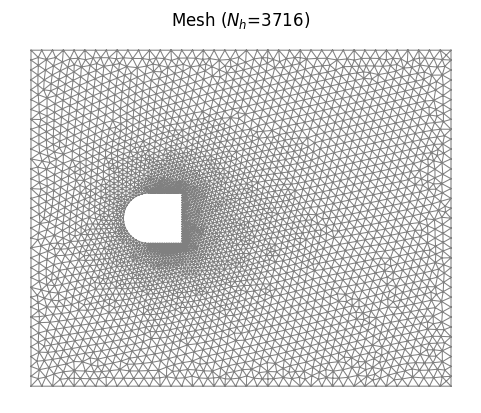

In [2]:
# IMPORT THE MESH FOR THE STATE PROBLEM

mesh = Mesh("Mesh/mesh.xml")
plot(mesh, color = "grey", linewidth = 0.75)
plt.axis("off");
plt.title("Mesh ($N_{h}$=%d)" % mesh.num_vertices());

In [3]:
# DEFINE AND MARK SUBDOMAINS AND BOUNDARY PORTIONS

dx = Measure("dx", domain = mesh) # Domain measure

class GammaOBS(SubDomain): # Obstacle boundary
    def inside(self, x, on_boundary):
        return on_boundary and between(x[1], (7.0, 13.0)) and between(x[0], (4.0, 10.0))
class GammaC(SubDomain):   # Control boundary
    def inside(self, x, on_boundary):
        return on_boundary and between(x[1], (7.0, 13.0)) and between(x[0], (4.0, 7.0))    
boundaries_state = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries_state.set_all(0)
GammaOBS().mark(boundaries_state, 1)
GammaC().mark(boundaries_state, 2)
ds = Measure("ds", domain = mesh, subdomain_data = boundaries_state) # Boundary measure

In [4]:
# DEFINE THE STATE SPACE

Vh = VectorFunctionSpace(mesh, "CG", 2) # Velocity space
Ph = FunctionSpace(mesh, "CG", 1) # Pressure space

nv = Vh.dim() # Velocity space dimension
npressure = Ph.dim() # Pressure space dimension

In [5]:
# GET THE CONTROL INDICES

bc_dummy = DirichletBC(Vh, (1.0, 2.0), boundaries_state, 2)
fun_dummy = Function(Vh)
bc_dummy.apply(fun_dummy.vector())

idx_control_x = fun_dummy.vector() == 1
idx_control_y = fun_dummy.vector() == 2
idx_control = idx_control_x | idx_control_y

nu = sum(idx_control == True) # Control region dimension

In [6]:
# DEFINE THE STATE PROBLEM SOLVER

mu = 1.0
mod_in = 10.0
beta = Constant(1e-1)

def boundary_conditions(param):
    """
    Definition of constant boundary conditions within the Chorin-Temam steps (once for all)
    """
    
    alpha_in = param[0]
    
    # Parabolic BC on the inflow
    v_in = Expression(('mod_in * cos(alpha_in)','0.01 * x[1] * (20.0 - x[1]) * mod_in * sin(alpha_in)'), degree = 1, mod_in = mod_in, alpha_in = alpha_in)  
    inflow = DirichletBC(Vh, v_in, "on_boundary && x[0] <= 0.01")
    
    # Free-slip BC on the wall
    wall = DirichletBC(Vh.sub(1), 0.0, "on_boundary && (x[1] >= 19.99 || x[1] < 0.01)")
    
    # No-slip BC on the obstacle
    obstacle = DirichletBC(Vh, (0.0, 0.0), "on_boundary && x[1] < 12 && x[1] > 8.0 && x[0] >= 7.0 && x[0] < 10.0")
    
    # BC for the velocity
    bcv = [inflow, wall, obstacle]
    
    # BC for the pressure
    bcp = DirichletBC(Ph, 0.0, "on_boundary && x[0] >= 24.99")
        
    return [bcv, bcp]

def chorin_assembly():
    """
    Assembly for the constant matrices within the Chorin-Temam steps (once for all)
    """
    
    w = TestFunction(Vh)
    q = TestFunction(Ph)
    v = TrialFunction(Vh)
    p = TrialFunction(Ph)

    # Matrix for the second Chorin-Temam step
    a2 = inner(grad(p), grad(q)) * dx
    A2 = assemble(a2)
    
    # Matrix for the third Chorin-Temam step
    a3 = inner(v, w) * dx
    A3 = assemble(a3)
    
    # Matrix for the fourth Chorin-Temam step
    a4 = p * q * dx
    A4 = assemble(a4)
    
    return [A2, A3, A4] 
    
def compute_state(param, ut, v0, p0, dt, T):
    """
    Solve the time-dependent Navier-Stokes equation via incremental Chorin-Temam projection method
    Input: scenario parameters, control function, initial state, time step and final time horizon
    Output: time-dependent state and cost function
    """
    
    alpha_in = param[0]
    
    w = TestFunction(Vh)
    q = TestFunction(Ph)
    v = TrialFunction(Vh)
    p = TrialFunction(Ph)
    v1 = Function(Vh)
    p1 = Function(Ph)
    u = Function(Vh)
          
    [bcv, bcp] = boundary_conditions(param)
    [A2, A3, A4] = chorin_assembly()
        
    vt = CPU.zeros(round(T / dt), nv)
    pt = CPU.zeros(round(T / dt), npressure)
    
    J = 0.5 * float(dt) * assemble(inner(grad(v0), grad(v0)) * dx) # Loss initialization
    
    i = 0
    t = float(dt)
    
    while t <= T:
        
        u.assign(ut[t])
        bc_control = DirichletBC(Vh, u, boundaries_state, 2)
        if i == 0:
            bcv.append(bc_control)
        else:
            bcv[-1] = bc_control
        
        # First Chorin-Temam step
        a1 = (1 / dt) * inner(v, w) * dx + inner(grad(v) * v0, w) * dx + mu * inner(grad(v), grad(w)) * dx 
        A1 = assemble(a1)
        L1 = (1 / dt) * inner(v0, w) * dx - inner(grad(p0), w) * dx
        b1 = assemble(L1)
        [bc.apply(A1, b1) for bc in bcv]
        solve(A1, v1.vector(), b1)
        
        # Second Chorin-Temam step
        L2 = - (1 / dt) * div(v1) * q * dx
        b2 = assemble(L2)
        bcp.apply(A2, b2)
        solve(A2, p1.vector(), b2)
        
        # Third Chorin-Temam step
        L3 = inner(v1, w) * dx - dt * inner(grad(p1), w) * dx
        b3 = assemble(L3)
        solve(A3, v1.vector(), b3)
        
        # Fourth Chorin-Temam step
        L4 = p0 * q * dx + p1 * q * dx
        b4 = assemble(L4)
        solve(A4, p1.vector(), b4)
        
        # Update the loss
        if t > T - float(dt):
            weight = 0.5
        else:
            weight = 1
        J += weight * float(dt) * assemble(inner(grad(v1), grad(v1)) * dx + beta * inner(u, u) * dx)

        v0.assign(v1)
        p0.assign(p1)
        vt[i] = CPU.tensor(v1.vector())
        pt[i] = CPU.tensor(p1.vector())
        i = i + 1
        t = t + float(dt)

    return [vt, pt, J]

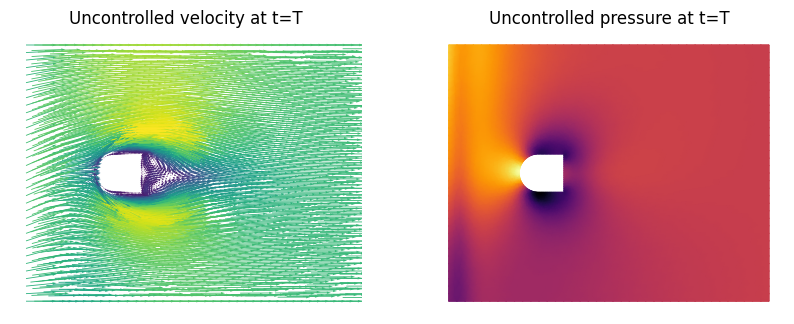

In [7]:
# SOLVE THE STATE PROBLEM SOLVER

dt = Constant(0.1)
T = 0.5
v0 = Function(Vh)
p0 = Function(Ph)
ut = OrderedDict() # Time-dependent control
t = float(dt)
while t <= T:
    ut[t] = Function(Vh) # Set the control for each time-step
    t += float(dt)

[vt, pt, J] = compute_state([0.4], ut, v0, p0, dt, T)

plt.figure(figsize = (10,8))

plt.subplot(1, 2, 1)
plt.title("Uncontrolled velocity at t=T");
fe.plot(vt[-1], Vh, scale = 100)

plt.subplot(1, 2, 2)
plt.title("Uncontrolled pressure at t=T");
fe.plot(pt[-1], Ph, cmap = "inferno")
plt.show()

# Snapshots generation

### PDE-constrained Optimisation

Consider the problem of minimising the drag coefficient

$$
\min_{\boldsymbol{v},\boldsymbol{u}} \frac{1}{2} \int_0^T \int_{\Omega} ||\nabla \boldsymbol{v}||^2 + \frac{\beta}{2} \int_0^T \int_{\Gamma_{\textrm{c}}} ||\boldsymbol{u}||^2  + \frac{\beta_g}{2}  \int_0^T 
\int_{\Gamma_{\textrm{c}}} ||\nabla \boldsymbol{u}||^2  \\
$$

Physically, this setup corresponds to minimising the loss of flow energy into heat by actively controlling the inflow/outflow at a portion of the obstacle boundary. To avoid overconsuming and irregular control solutions, the norms of the control and its gradient are penalised via the regularisation terms.

In [ ]:
# GENERATE SNAPSHOTS

from dlroms.ocp import snapshots

dt = Constant(0.05)
T = 0.5
ntimesteps = round(T / dt)

nsnapshots = 22
ntrain = 18
ntrain *= ntimesteps
nparams = 2

ranges = [(0.0, 1.0)] # Scenario paramters: alpha_in

set_working_tape(Tape()) # Reset forward model annotated by dolfin adjoint 

def sampler(seed):
    """
    Generate a random sample of scenario parameters and the corresponding optimal pair
    Input: seed
    Output: scenario parameters, optimal state and control
    """
    params = [0] * len(ranges)
    for i in range(len(ranges)):
            params[i] = ((ranges[i][1] - ranges[i][0]) * CPU.rand() + ranges[i][0]).item()    

    v0 = Function(Vh)
    p0 = Function(Ph)
    ut = OrderedDict()
    t = float(dt)
    while t <= T:
        ut[t] = Function(Vh) # Initialize one control for each time-step
        t += float(dt) 

    v0_copy = v0.copy(deepcopy = True) # Copy v0 since it will be modified in compute_state
    p0_copy = p0.copy(deepcopy = True) # Copy p0 since it will be modified in compute_state
    
    [vt, pt, J] = compute_state(params, ut, v0, p0, dt, T)

    control = [Control(u) for u in ut.values()]      
    Jhat = ReducedFunctional(J, control)
    
    ut_opt_list = minimize(Jhat, method = 'L-BFGS-B', options = {'disp': True, 'maxiter': 1000})
    ut_opt = OrderedDict()
    t = float(dt)
    i = 0
    while t <= T:
        ut_opt[t] = ut_opt_list[i]
        t += float(dt)
        i += 1
    [vt_opt, pt_opt, J_opt] = compute_state(params, ut_opt, v0_copy, p0_copy, dt, T)

    set_working_tape(Tape())    

    ut_opt_vals = CPU.zeros(ntimesteps, nu)
    j = 0
    for k in ut_opt.keys():
        ut_opt_vals[j] = CPU.tensor(ut_opt[k].vector()[idx_control])
        j += 1

    params_vals = CPU.zeros(ntimesteps, nparams)
    for j in range(ntimesteps):
        params_vals[j,0:(nparams - 1)] = CPU.tensor(params)
        params_vals[j,(nparams - 1):] = (j + 1) * float(dt)

    return params_vals, vt_opt, ut_opt_vals

snapshots(nsnapshots, sampler, core = CPU, verbose = True, filename = 'Data/UnsteadyNavier-Stokes')

In [8]:
# LOAD SNAPSHOTS MATRICES

dt = Constant(0.05)
T = 0.5
ntimesteps = round(T / dt)

nsnapshots = 22
ntrain = 18
ntrain *= ntimesteps
nparams = 2

ranges = [(0.0, 1.0)] # Scenario paramters: alpha_in

filename = 'Data/UnsteadyNavier-Stokes'
Data = np.load("%s.npz" % filename.replace(".npz",""))

MU = CPU.tensor(Data["mu"])
V = CPU.tensor(Data["y"])
U = CPU.tensor(Data["u"])

In [9]:
# RESHAPE MATRICES

V = V.reshape(-1, nv)
U = U.reshape(-1, nu)
MU = MU.reshape(-1, nparams)

In [10]:
# SPLIT MATRICES OF VECTOR FIELDS

Vx = V[:, 0 : nv : 2]
Vy = V[:, 1 : nv : 2]
Ux = U[:, 0 : nu : 2]
Uy = U[:, 1 : nu : 2]

In [11]:
# SHUFFLING

idx = CPU.zeros(nsnapshots * ntimesteps)
idx = torch.load('Data/idx.pt')
MU_perm = MU[idx,:]
Ux_perm = Ux[idx,:]
Uy_perm = Uy[idx,:]
U_perm = U[idx,:]
Vx_perm = Vx[idx,:]
Vy_perm = Vy[idx,:]
V_perm = V[idx,:]

In [12]:
# CREATE MATRICES WITH CONTROL ON THE ENTIRE DOMAIN TO COMPUTE ERRORS

Ux_extended = CPU.zeros(nsnapshots * ntimesteps, nv // 2)
Uy_extended = CPU.zeros(nsnapshots * ntimesteps, nv // 2)
Ux_extended[:, idx_control_x[0 : nv : 2]] = Ux_perm
Uy_extended[:, idx_control_y[1 : nv : 2]] = Uy_perm

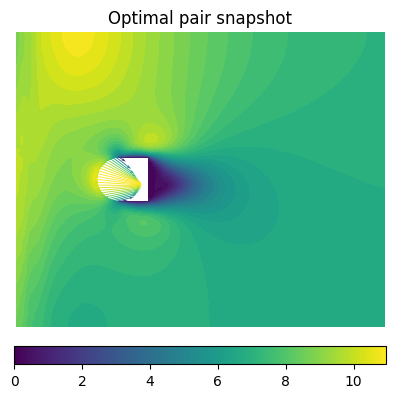

In [13]:
# SNAPSHOT EXAMPLE (PLOT)

which = -1

v = Function(Vh)
v.vector()[:] = V[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
u = CPU.zeros(nv)
u[idx_control] = U[which]
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 0.75, orientation = "horizontal", pad = 0.05)
fe.plot(u, Vh, colorbar = False, scale = 90, minlength = 0)
plt.title("Optimal pair snapshot");
plt.axis('off');

# POD-DL-ROM

In [14]:
# IMPORT FUNCTIONS FOR POD AND NEURAL NETWORKS

from dlroms.dnns import Dense # Neural networks handling
from dlroms.roms import projectup, mre, mse, euclidean # Proper orthogonal decomposition
from dlroms.ocp import L2, Linf # Error metrics

l2_state = L2(mesh, Vh, measure = dx, core = CPU)
l2_control = L2(mesh, Vh, measure = ds(2), core = CPU)
linf = Linf()

mse = mse(euclidean)
mre = mre(euclidean)

In [15]:
# DEFINE THE OCP OBJECT TO HANDLE REDUCTIONS AND PREDICTIONS

from dlroms.ocp import OCP

ocp = OCP(ntrain)

## State reduction - POD+AE

In [16]:
# POD+AE for Vx

k_Vx = 70 # Number of POD modes
n_Vx = 3 # Latent dimension
encoder_Vx = Dense(k_Vx, 50) + Dense(50, n_Vx)
decoder_Vx = Dense(n_Vx, 50) + Dense(50, 50) + Dense(50, k_Vx, activation = None)

Vx_DLROM, Vx_reconstructed, pod_Vx, eig_Vx = ocp.PODAE(Vx_perm, k = k_Vx, encoder = encoder_Vx, decoder = decoder_Vx, training = False, save = False, path = 'NN/UnsteadyFlowControl/autoencoder_Vx.pt', decay = False, epochs = 1000, optim = torch.optim.LBFGS, lossf = mse, error = mre, best = True)

In [17]:
# POD+AE for Vy

k_Vy = 70 # Number of POD modes
n_Vy = 3 # Latent dimension
encoder_Vy = Dense(k_Vy, 50) + Dense(50, n_Vy)
decoder_Vy = Dense(n_Vy, 50) + Dense(50, 50) + Dense(50, k_Vy, activation = None)

Vy_DLROM, Vy_reconstructed, pod_Vy, eig_Vy = ocp.PODAE(Vy_perm, k = k_Vy, encoder = encoder_Vy, decoder = decoder_Vy, training = False, save = False, path = 'NN/UnsteadyFlowControl/autoencoder_Vy.pt', decay = False, epochs = 1000, optim = torch.optim.LBFGS, lossf = mse, error = mre, best = True)

In [18]:
# POD+AE RECONSTRUCTION ERRORS ON TEST DATA

print("POD+AE reconstruction errors:")
print("")
print("Mean relative error on Vx: %s." % num2p(mre(Vx_perm[ntrain:], Vx_reconstructed[ntrain:])))
print("Mean relative error on Vy: %s." % num2p(mre(Vy_perm[ntrain:], Vy_reconstructed[ntrain:])))
print("L2 mean relative error on Vx: %s." % num2p(l2_state.mre(Vx_perm[ntrain:], Vx_reconstructed[ntrain:])))
print("L2 mean relative error on Vy: %s." % num2p(l2_state.mre(Vy_perm[ntrain:], Vy_reconstructed[ntrain:])))
print("L2 mean relative error on V: %s." % num2p(l2_state.mre_vect(Vx_perm[ntrain:], Vx_reconstructed[ntrain:], Vy_perm[ntrain:], Vy_reconstructed[ntrain:])))

POD+AE reconstruction errors:

Mean relative error on Vx: 0.40%.
Mean relative error on Vy: 0.60%.
L2 mean relative error on Vx: 0.30%.
L2 mean relative error on Vy: 0.67%.
L2 mean relative error on V: 0.32%.


## Control reduction - POD+AE

In [19]:
# POD+AE for Ux

k_Ux = 40 # Number of POD modes
n_Ux = 3 # Latent dimension
encoder_Ux = Dense(k_Ux, 25) + Dense(25, n_Ux)
decoder_Ux = Dense(n_Ux, 25) + Dense(25, 25) + Dense(25, k_Ux, activation = None)

Ux_DLROM, Ux_reconstructed, pod_Ux, eig_Ux = ocp.PODAE(Ux_perm, k = k_Ux, encoder = encoder_Ux, decoder = decoder_Ux, training = False, save = False, path = 'NN/UnsteadyFlowControl/autoencoder_Ux.pt', decay = False, epochs = 1000, optim = torch.optim.LBFGS, lossf = mse, error = mre, best = True)

In [20]:
# POD+AE for Ux

k_Uy = 40 # Number of POD modes
n_Uy = 3 # Latent dimension
encoder_Uy = Dense(k_Uy, 25) + Dense(25, n_Uy)
decoder_Uy = Dense(n_Uy, 25) + Dense(25, 25) + Dense(25, k_Uy, activation = None)

Uy_DLROM, Uy_reconstructed, pod_Uy, eig_Uy = ocp.PODAE(Uy_perm, k = k_Uy, encoder = encoder_Uy, decoder = decoder_Uy, training = False, save = False, path = 'NN/UnsteadyFlowControl/autoencoder_Uy.pt', decay = False, epochs = 1000, optim = torch.optim.LBFGS, lossf = mse, error = mre, best = True)

In [21]:
# POD+AE reconstruction errors on test data

Ux_reconstructed_extended = CPU.zeros(nsnapshots * ntimesteps, nv // 2)
Uy_reconstructed_extended = CPU.zeros(nsnapshots * ntimesteps, nv // 2)
Ux_reconstructed_extended[:, idx_control_x[0 : nv : 2]] = Ux_reconstructed
Uy_reconstructed_extended[:, idx_control_y[1 : nv : 2]] = Uy_reconstructed

print("POD+AE reconstruction errors:")
print("")
print("Mean relative error on Ux: %s." % num2p(mre(Ux_extended[ntrain:], Ux_reconstructed_extended[ntrain:])))
print("Mean relative error on Uy: %s." % num2p(mre(Uy_extended[ntrain:], Uy_reconstructed_extended[ntrain:])))
print("L2 mean relative error on Ux: %s." % num2p(l2_control.mre(Ux_extended[ntrain:], Ux_reconstructed_extended[ntrain:])))
print("L2 mean relative error on Uy: %s." % num2p(l2_control.mre(Uy_extended[ntrain:], Uy_reconstructed_extended[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux_extended[ntrain:], Ux_reconstructed_extended[ntrain:], Uy_extended[ntrain:], Uy_reconstructed_extended[ntrain:])))

POD+AE reconstruction errors:

Mean relative error on Ux: 0.73%.
Mean relative error on Uy: 0.71%.
L2 mean relative error on Ux: 0.70%.
L2 mean relative error on Uy: 0.70%.
L2 mean relative error on U: 0.70%.


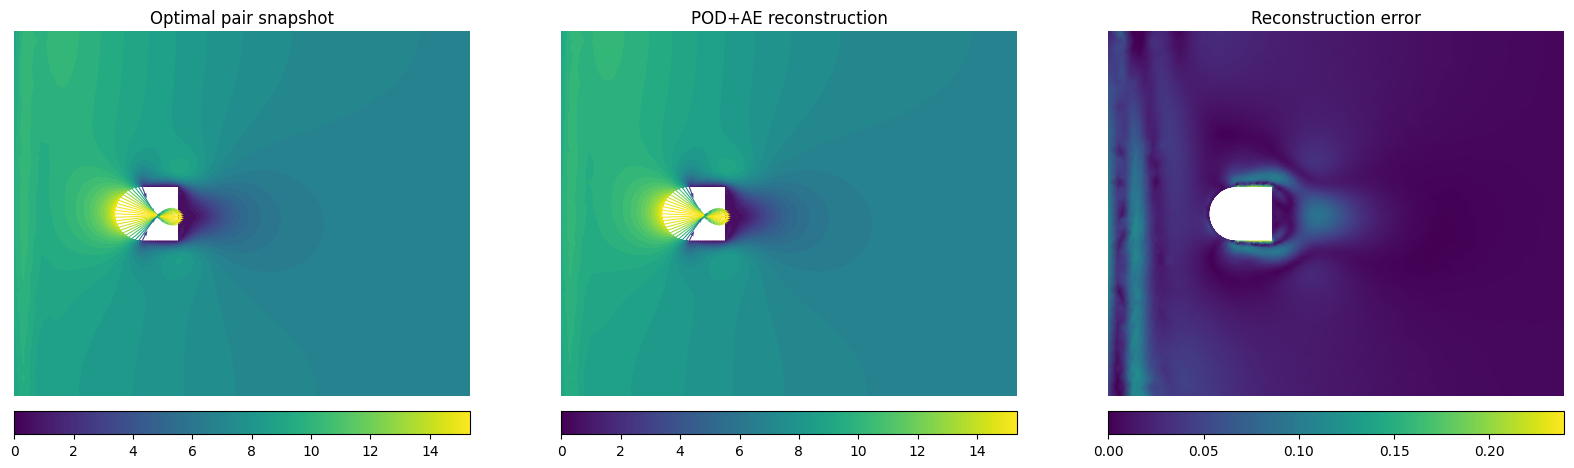

In [22]:
# FOM vs POD+AE RECONSTRUCTION (PLOTS)

which = -1

U_reconstructed = CPU.zeros(nsnapshots * ntimesteps, nu)
U_reconstructed[:, 0 : nu : 2] = Ux_reconstructed
U_reconstructed[:, 1 : nu : 2] = Uy_reconstructed

V_reconstructed = CPU.zeros(nsnapshots * ntimesteps, nv)
V_reconstructed[:, 0 : nv : 2] = Vx_reconstructed
V_reconstructed[:, 1 : nv : 2] = Vy_reconstructed

plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
u = CPU.zeros(nv)
u[idx_control] = U_perm[which]
v = Function(Vh)
v.vector()[:] = V_perm[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 100, minlength = 0)
plt.title("Optimal pair snapshot");
plt.axis('off');

plt.subplot(1,3,2)
u = CPU.zeros(nv)
u[idx_control] = U_reconstructed[which]
v = Function(Vh)
v.vector()[:] = V_reconstructed[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 100, minlength = 0)
plt.title("POD+AE reconstruction");
plt.axis('off');

plt.subplot(1,3,3)
u = CPU.zeros(nv)
u[idx_control] = ((U_perm[which] - U_reconstructed[which])**2).sqrt()
v = Function(Vh)
v.vector()[:] = V_perm[which] - V_reconstructed[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
plot(v_norm)
fig = plot(v_norm, vmin = 0.0, mode = "color")
plt.colorbar(fig, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 100, minlength = 0)
plt.title("Reconstruction error");
plt.axis('off');

## Parameter-to-solution map $\boldsymbol{\mu}_s \to ( \mathbf{u}_{POD+AE}, \mathbf{y}_{POD+AE} )$ 


In [23]:
# NN TO MAP PARAMETERS IN REDUCED OPTIMAL STATE AND CONTROL

phi = Dense(nparams, 150) + Dense(150, 150) + Dense(150, n_Vx + n_Vy + n_Ux + n_Uy, activation = None)

VU_DLROM = [Vx_DLROM, Vy_DLROM, Ux_DLROM, Uy_DLROM]

VU_DLROM_hat = ocp.redmap(phi, MU_perm, VU_DLROM, minmax = False, load = True, training = False, save = False, path = 'NN/UnsteadyFlowControl/phi.pt', epochs = 1000, optim = torch.optim.LBFGS, lossf = mse, error = mre, best = True)

In [24]:
# POD-DL-ROM PREDICTION ERRORS ON TEST DATA

Vx_DLROM_hat = VU_DLROM_hat[0]
Vy_DLROM_hat = VU_DLROM_hat[1]
Ux_DLROM_hat = VU_DLROM_hat[2]
Uy_DLROM_hat = VU_DLROM_hat[3]

Ux_AE_hat = decoder_Ux(Ux_DLROM_hat)
Uy_AE_hat = decoder_Uy(Uy_DLROM_hat)
Vx_AE_hat = decoder_Vx(Vx_DLROM_hat)
Vy_AE_hat = decoder_Vy(Vy_DLROM_hat)

Ux_hat = projectup(pod_Ux, Ux_AE_hat)
Uy_hat = projectup(pod_Uy, Uy_AE_hat)
Vx_hat = projectup(pod_Vx, Vx_AE_hat)
Vy_hat = projectup(pod_Vy, Vy_AE_hat)

Ux_hat_extended = CPU.zeros(nsnapshots * ntimesteps, nv // 2)
Uy_hat_extended = CPU.zeros(nsnapshots * ntimesteps, nv // 2)
Ux_hat_extended[:, idx_control_x[0 : nv : 2]] = Ux_hat
Uy_hat_extended[:, idx_control_y[1 : nv : 2]] = Uy_hat

print("POD-DL-ROM prediction errors:")
print("")
print("Mean relative error on Vx: %s." % num2p(mre(Vx_perm[ntrain:], Vx_hat[ntrain:])))
print("Mean relative error on Vy: %s." % num2p(mre(Vy_perm[ntrain:], Vy_hat[ntrain:])))
print("L2 mean relative error on Vx: %s." % num2p(l2_state.mre(Vx_perm[ntrain:], Vx_hat[ntrain:])))
print("L2 mean relative error on Vy: %s." % num2p(l2_state.mre(Vy_perm[ntrain:], Vy_hat[ntrain:])))
print("L2 mean relative error on V: %s." % num2p(l2_state.mre_vect(Vx_perm[ntrain:], Vx_hat[ntrain:], Vy_perm[ntrain:], Vy_hat[ntrain:])))
print("")
print("Mean relative error on Ux: %s." % num2p(mre(Ux_perm[ntrain:], Ux_hat[ntrain:])))
print("Mean relative error on Uy: %s." % num2p(mre(Uy_perm[ntrain:], Uy_hat[ntrain:])))
print("L2 mean relative error on Ux: %s." % num2p(l2_control.mre(Ux_extended[ntrain:], Ux_hat_extended[ntrain:])))
print("L2 mean relative error on Uy: %s." % num2p(l2_control.mre(Uy_extended[ntrain:], Uy_hat_extended[ntrain:])))
print("L2 mean relative error on U: %s." % num2p(l2_control.mre_vect(Ux_extended[ntrain:], Ux_hat_extended[ntrain:], Uy_extended[ntrain:], Uy_hat_extended[ntrain:])))

POD-DL-ROM prediction errors:

Mean relative error on Vx: 0.43%.
Mean relative error on Vy: 0.95%.
L2 mean relative error on Vx: 0.34%.
L2 mean relative error on Vy: 1.09%.
L2 mean relative error on V: 0.37%.

Mean relative error on Ux: 0.85%.
Mean relative error on Uy: 1.04%.
L2 mean relative error on Ux: 0.82%.
L2 mean relative error on Uy: 1.05%.
L2 mean relative error on U: 0.85%.


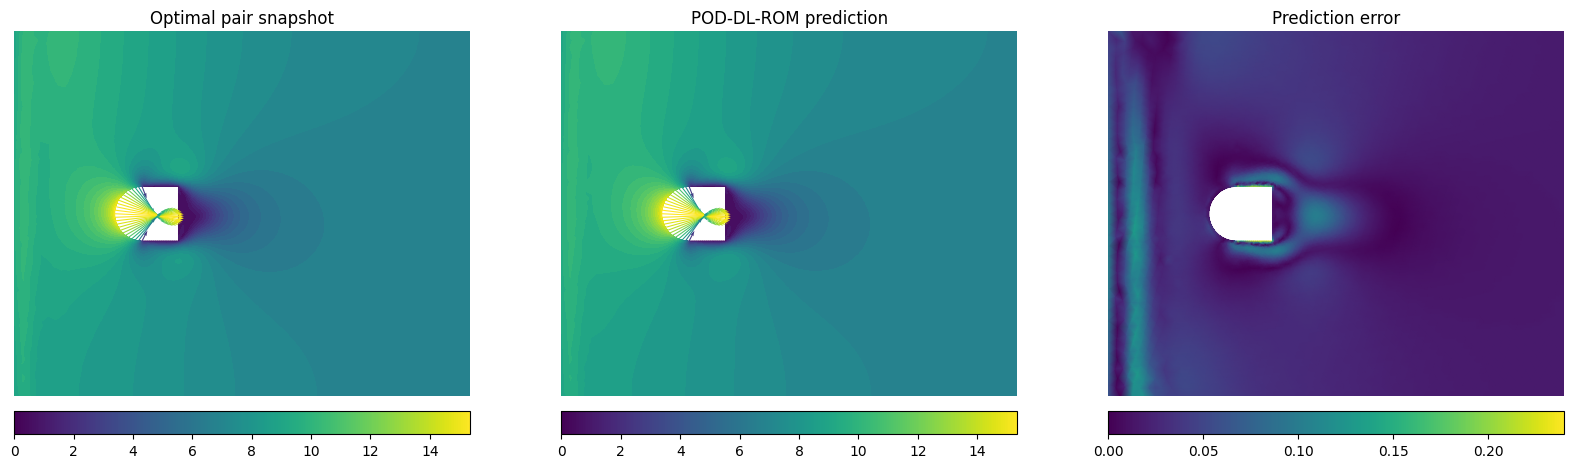

In [25]:
# FOM vs POD-DL-ROM PREDICTION (PLOTS)

which = -1

U_hat = CPU.zeros(nsnapshots * ntimesteps, nu)
U_hat[:, 0 : nu : 2] = Ux_hat
U_hat[:, 1 : nu : 2] = Uy_hat

V_hat = CPU.zeros(nsnapshots * ntimesteps, nv)
V_hat[:, 0 : nv : 2] = Vx_hat
V_hat[:, 1 : nv : 2] = Vy_hat

plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
u = CPU.zeros(nv)
u[idx_control] = U_perm[which]
v = Function(Vh)
v.vector()[:] = V_perm[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 100, minlength = 0)
plt.title("Optimal pair snapshot");
plt.axis('off');

plt.subplot(1,3,2)
u = CPU.zeros(nv)
u[idx_control] = U_hat[which]
v = Function(Vh)
v.vector()[:] = V_hat[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm)
plt.colorbar(fig_dummy, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 100, minlength = 0)
plt.title("POD-DL-ROM prediction");
plt.axis('off');

plt.subplot(1,3,3)
u = CPU.zeros(nv)
u[idx_control] = ((U_perm[which] - U_hat[which])**2).sqrt()
v = Function(Vh)
v.vector()[:] = V_perm[which] - V_hat[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
plot(v_norm)
fig = plot(v_norm, vmin = 0.0, mode = "color")
plt.colorbar(fig, shrink = 1, orientation = "horizontal", pad = 0.01)
fe.plot(u, Vh, colorbar = False, scale = 100, minlength = 0)
plt.title("Prediction error");
plt.axis('off');

# Test case: solve the time-dependent OCP for a fixed angle of attack

In [26]:
# CREATE TEST PARAMETERS

alpha_in_test = 0.5 # Fixed angle of attack
dt = Constant(0.025)
T = 0.5
ntimesteps = round(T / dt)

MU_test = CPU.zeros(ntimesteps, nparams)

for j in range(ntimesteps):
    MU_test[j,0] = alpha_in_test
    MU_test[j,1] = float(dt) + (j + 1) * float(dt)

In [27]:
# COMPUTE OPTIMAL STATE AND CONTROL

Vx_test_DLROM_hat, Vy_test_DLROM_hat, Ux_test_DLROM_hat, Uy_test_DLROM_hat = ocp.redmap(phi, MU_test, VU_DLROM, minmax = False, training = False, save = False)

Vx_test_hat = projectup(pod_Vx, decoder_Vx(Vx_test_DLROM_hat))
Vy_test_hat = projectup(pod_Vy, decoder_Vy(Vy_test_DLROM_hat))
Ux_test_hat = projectup(pod_Ux, decoder_Ux(Ux_test_DLROM_hat))
Uy_test_hat = projectup(pod_Uy, decoder_Uy(Uy_test_DLROM_hat))

U_test_hat = CPU.zeros(ntimesteps, nu)
U_test_hat[:, 0 : nu : 2] = Ux_test_hat
U_test_hat[:, 1 : nu : 2] = Uy_test_hat

V_test_hat = CPU.zeros(ntimesteps, nv)
V_test_hat[:, 0 : nv : 2] = Vx_test_hat
V_test_hat[:, 1 : nv : 2] = Vy_test_hat

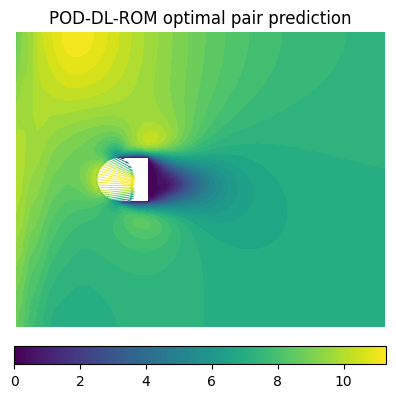

In [28]:
# POD-DL-ROM PREDICTION (PLOT)

which = -1

u = CPU.zeros(nv)
u[idx_control] = U_test_hat[which]
v = Function(Vh)
v.vector()[:] = V_test_hat[which]
v_norm = project(sqrt(inner(v, v)), Vh.sub(1).collapse())  
fig_dummy = plot(v_norm, vmin = 0.0, mode = "color")
plot(v_norm, vmin = 0.0)
plt.colorbar(fig_dummy, shrink = 0.75, orientation = "horizontal", pad = 0.05)
fe.plot(u, Vh, colorbar = False, scale = 100, minlength = 0)
plt.title("POD-DL-ROM optimal pair prediction");
plt.axis('off');